### Imports

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import os
import mne
import torch
from torch import Tensor
import joblib
from collections import OrderedDict
from numpy.random.mtrand import RandomState
from scipy import linalg
from scipy import signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


sys.path.append('/home/samuelboehm/boehms/eeg-gan/EEG-GAN/EEG-GAN/')

from eeggan.examples.high_gamma.make_data import load_dataset, load_deeps4
from eeggan.examples.high_gamma.dataset import HighGammaDataset
from eeggan.cuda import  init_cuda, to_cuda
from eeggan.data.dataset import Data
from eeggan.plotting.plots import labeled_plot, labeled_tube_plot
from eeggan.validation.validation_helper import compute_spectral_amplitude
from eeggan.data.preprocess.resample import downsample


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define helper functions

In [4]:
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def spectral_plot(X_real: np.ndarray, X_fake: np.ndarray, fs, axes=None, l1='first', l2='second'):#
    '''plots amplitude spectrum'''
    n_samples = X_real.shape[2]
    freqs = np.fft.rfftfreq(n_samples, 1. / fs)
    amps_real = compute_spectral_amplitude(X_real, axis=2)
    amps_real_mean = amps_real.mean(axis=(0, 1)).squeeze()
    amps_real_std = amps_real.std(axis=(0, 1)).squeeze()
    amps_fake = compute_spectral_amplitude(X_fake, axis=2)
    amps_fake_mean = amps_fake.mean(axis=(0, 1)).squeeze()
    amps_fake_std = amps_fake.std(axis=(0, 1)).squeeze()
    labeled_tube_plot(freqs,
                      [amps_real_mean, amps_fake_mean],
                      [amps_real_std, amps_fake_std],
                      [l1, l2],
                      "Mean spectral log amplitude", "Hz", "log(Amp)", axes)
    

def load_GAN(path: str, stage: int):
    '''loads a pretrained gan from path and sets a current stage'''
    stateDict = torch.load(os.path.join(path, f'states_stage_{stage}.pt'))
    
    # original saved file with DataParallel
    generator_state_dict = OrderedDict()
    for k, v in stateDict['generator'].items():
        name = k.replace('module.', '') # removing ‘.moldule’ from key
        generator_state_dict[name] = v
    
    discriminator_state_dict = OrderedDict()
    for k, v in stateDict['discriminator'].items():
        name = k.replace('module.', '') # removing ‘.moldule’ from key
        discriminator_state_dict[name] = v

    model_builder =  joblib.load(os.path.join(path, 'model_builder.jblb'))
    
    # Initiate discriminator and generator
    discriminator = model_builder.build_discriminator()
    generator = model_builder.build_generator()
    
    generator.load_state_dict(generator_state_dict)
    discriminator.load_state_dict(discriminator_state_dict)
    
    generator.cur_block = stage
    discriminator.cur_block = 6 - stage - 1
    return generator, discriminator


def create_fake_data(model_path, stage, n_samples, balanced = True):
    generator, discriminator = load_GAN(model_path, stage - 1)

    latent, y_fake, y_onehot_fake = generator.create_latent_input(RandomState(), n_samples, balanced)

    X_fake =  generator(latent, y=y_fake).detach().numpy()
    return Data(X_fake, y_fake, y_onehot_fake)


def create_balanced_datasets(gan_path, data_path, data_name, stage, subject=None, return_on_cuda=False, n_samples=256):
    # loading real data...
    real = load_dataset(data_name, data_path)
    
    if subject:
        real.train_data = real.train_data.return_subject(subject)
        real.test_data = real.test_data.return_subject(subject)

    real.train_data.X = np.concatenate((real.train_data.X[:], real.test_data.X[:]), axis=0)
    real.train_data.y = np.concatenate((real.train_data.y[:], real.test_data.y[:]), axis=0)
    real.train_data.y_onehot = np.concatenate((real.train_data.y_onehot[:], real.test_data.y_onehot[:]), axis=0)

    # If there is a disbalance in the real dataset drop rows to balance the real dataset
    real = balance_dataset(real)

    real = real.train_data.subset(n_samples)
    
    real.X = downsample(real.X, factor=2 ** (6-stage), axis =2)

    # generating fake data...

    n_samples = real.X.shape[0]

    # Data is generated in batches of 1000 to make it work on lesser memory
    batches = []
    while n_samples > 1000:
        batches.append(1000)
        n_samples -= 1000
    batches.append(n_samples)

    fake = create_fake_data(gan_path, stage, batches[0])

    for i in batches[1:]:
        temp_fake = create_fake_data(gan_path, stage, i)
        fake.add_data(temp_fake.X, temp_fake.y, temp_fake.y_onehot, 1)

    if return_on_cuda:
        init_cuda()
        real = Data(*to_cuda(Tensor(real.X), Tensor(real.y), Tensor(real.y_onehot)))
        fake = Data(*to_cuda(Tensor(fake.X), Tensor(fake.y), Tensor(fake.y_onehot)))
    
    return real, fake

def balance_dataset(data: HighGammaDataset):
    label_counts =  np.unique(data.train_data.y, return_counts=True)
    smallest_dataset = label_counts[1].min()
    idx = list()
    for i in label_counts[0]:
        idx.append(np.where(data.train_data.y == i)[0][:smallest_dataset])

    idx = np.array(idx).flatten()
    data.train_data.y = data.train_data.y[idx]
    data.train_data.y_onehot = data.train_data.y_onehot[idx]
    data.train_data.X = data.train_data.X[idx]
    return data 

def plot_topographic(X_real, X_fake, fs, input_length, channels, times = np.arange(-.5, 1.5, 0.25)):
    n_channels = len(channels)
    ch_type = ['eeg'] * n_channels
    info = mne.create_info(channels, ch_types=ch_type, sfreq=fs)
    info.set_montage('standard_1020')

    # Create real evoked set: 
    info['description'] = 'real'
    evoked_real = mne.EvokedArray(X_real.mean(axis=0), info, tmin=-0.5,
                               nave=X_real.shape[0], comment='real')
    # Create fake evoked set:
    info['description'] = 'fake'
    evoked_fake = mne.EvokedArray(X_fake.mean(axis=0), info, tmin=-0.5,
                               nave=X_fake.shape[0], comment='fake')

    # Setting axis ratios: 
    ratio = [1] * len(times)
    ratio.append(.3)

    figure, axs = plt.subplots(2, len(times)+1,  figsize=(int(len(times)), 2), facecolor='w',
                                gridspec_kw={'width_ratios': ratio})
    
    plt.figtext(-.025, 0.75, 'Real', fontsize=14)
    plt.figtext(-.025, 0.25, 'Fake', fontsize=14)

    evoked_real.plot_topomap(times, average=0.1, show_names=False, ch_type='eeg', time_unit='s', image_interp='nearest', contours=0, axes=axs[0], show=False)
    evoked_fake.plot_topomap(times, average=0.1, show_names=False, ch_type='eeg', time_unit='s', image_interp='nearest', contours=0, axes=axs[1], show=False)
    plt.tight_layout()

### plot topographics 

In [11]:
gan_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/continue_on_sub_stage3/rest_right/'
data_path =  '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/'
data_name = 'rest_right'
stage = 4
subject = 4

real, fake = create_balanced_datasets(gan_path, data_path, data_name, stage, subject)


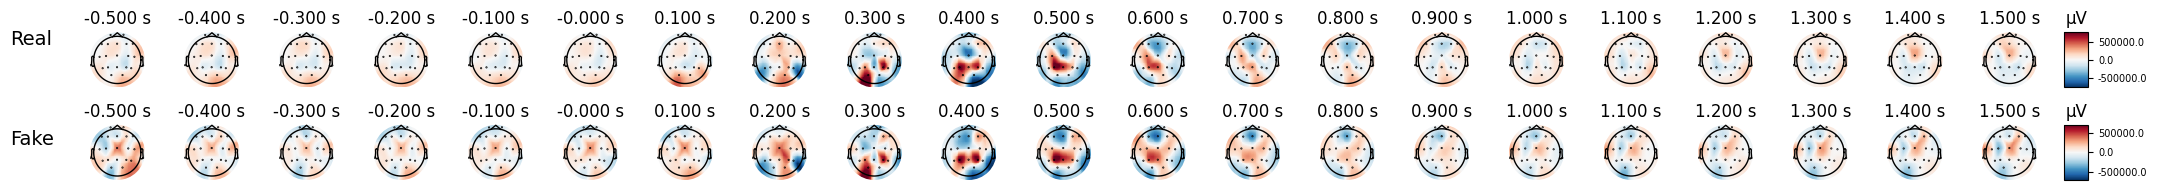

In [157]:
CHANNELS = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'M1', 'M2']
FS = 128
SEGMENT_IVAL = (-0.5, 4.00)
INPUT_LENGTH = int((SEGMENT_IVAL[1] - SEGMENT_IVAL[0]) * FS)

plot_topographic(real.X, fake.X, fs=FS, input_length=INPUT_LENGTH, channels=CHANNELS, times = np.arange(-.5, 1.5+0.1, 0.1)) 


### Plot Metrics

In [4]:
def metrics_to_df(stages: int, path: str):
    dataframes = []
    for i in range(stages):
        metrics = torch.load(os.path.join(path, f'metrics_stage_{i}.pt'))

        df = pd.DataFrame(metrics)

        # extract epochs
        epoch = list(list(zip(*df['wasserstein']))[0])

        # Unzip tuples and remove epoch information
        for column in df.columns:
            df[column] = list(zip(*df[column]))[1]

        # Add extra epoch column
        df['epoch'] = epoch

        # Unzip mean and std from inception score
        df['inception sdt'] = list(zip(*df['inception']))[1]
        df['inception'] = list(zip(*df['inception']))[0]

        # Unzip mean and std from classification (discard std)
        df['classification'] = list(zip(*df['classification']))[0]

        # Unpack the loss dict and concat it to the dataframe
        loss_df = pd.json_normalize(df['loss'])
        df = df.drop('loss', axis=1)

        df = pd.concat([df, loss_df], axis=1)

        dataframes.append(df)

    df = pd.concat(dataframes)
    return df

In [161]:
cGAN_path = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/cGAN/1-14/'
pgGAN_path = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/full_set_1_2/1-14/'

cGAN_df = metrics_to_df(5, cGAN_path)
pgGAN_df = metrics_to_df(5, pgGAN_path)

deep4_dict = joblib.load('/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Models/ZCA_prewhitened/1-14_stage4_0deep4_log.dict')


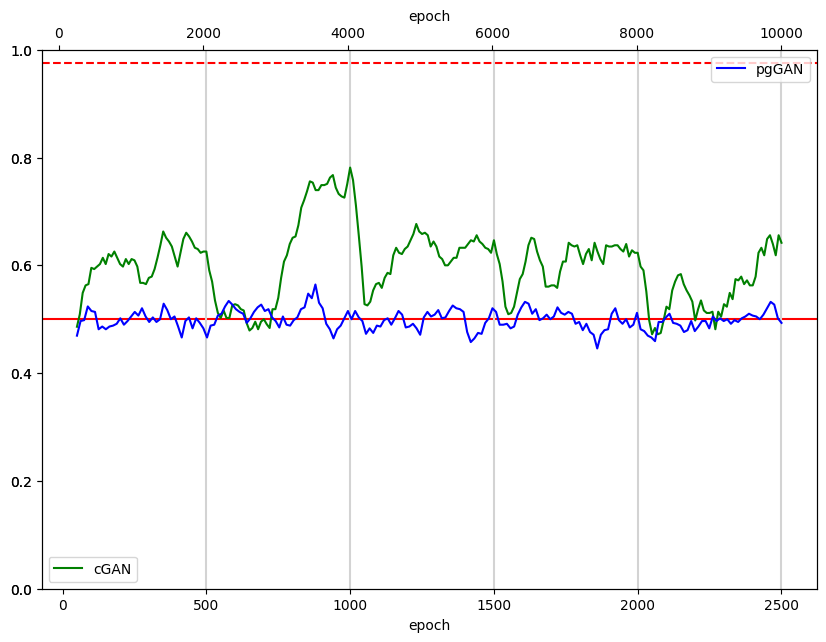

In [164]:
fig = plt.gcf()
fig.set_size_inches(10, 7)

ax = plt.gca()

plt.axhline(y=0.5, color='r', linestyle='-')
plt.axhline(y=deep4_dict['training_acc'][-1]/100, color='r', linestyle='--')

ax.vlines(x=[500,1000,1500,2000,2500], ymin=1.1, ymax=-.1, color='lightgrey')


ax2 = ax.twiny()

cGAN_df['classification_rm'] = cGAN_df['classification'].rolling(5).mean()
pgGAN_df['classification_rm'] = pgGAN_df['classification'].rolling(5).mean()



cGAN_df.plot(kind='line', x='epoch', y='classification_rm', ax=ax, color='g', label='cGAN')
pgGAN_df.plot(kind='line', x='epoch', y='classification_rm', ax=ax2, color='b', label='pgGAN')


ax.set_ylim(0,1)


plt.show()

### Calculate Metrics for Network

In [28]:
from eeggan.examples.high_gamma.braindecode_hack import IntermediateOutputWrapper
from eeggan.training.handlers.metrics import WassersteinMetric, InceptionMetric, LossMetric, ClassificationMetric, FrechetMetric
from torch import Tensor
import pandas as pd

class BatchOutput:
    def __init__(self, batch_real: Data[torch.Tensor], batch_fake: Data[torch.Tensor], i_epoch: int = 0):
        self.i_epoch = i_epoch
        self.batch_real = batch_real
        self.batch_fake = batch_fake

def calculate_metrics(real, fake, stage, data_name, batchsize, deep4_path):
    
    # Draw n_samples random samples from the real data set
    random_sample = np.random.randint(0, real.X.shape[0], batchsize)
    batch_real1 = real.subset(random_sample)
    batch_fake = fake.subset(random_sample)
    
    random_sample = np.random.randint(0, real.X.shape[0], batchsize)
    batch_real2 = real.subset(random_sample)
    batch_fake2 = fake.subset(random_sample)

    realVSreal = BatchOutput(batch_real1, batch_real2)
    realVSfake = BatchOutput(batch_real1, batch_fake)
    fakeVSfake = BatchOutput(batch_fake, batch_fake2)
    
    batches = [realVSreal, realVSfake, fakeVSfake]
    batch_names = ['real vs real', 'real vs fake', 'fake vs fake']
    
    # load trained deep4s for stage
    deep4s = load_deeps4(data_name, stage-1, deep4_path)

    select_modules = ['pool_4', 'softmax']
    deep4s = [to_cuda(IntermediateOutputWrapper(select_modules, deep4)) for deep4 in deep4s]

    # initiate metrics
    metric_wasserstein = WassersteinMetric(100, np.prod(batch_real1.X.shape[1:]).item(), tb_writer=None)
    
    sample_factor = 2 ** (6 - stage)
    metric_inception = InceptionMetric(deep4s, sample_factor, tb_writer=None)
    metric_frechet = FrechetMetric(deep4s, sample_factor, tb_writer=None)

    metric_classification = ClassificationMetric(deep4s, sample_factor, tb_writer=None)


    
    metrics = [metric_wasserstein, metric_inception, metric_classification, metric_frechet]
    metric_names = ['SWD', 'IS', 'classification', 'FID']
    
    df = pd.DataFrame()
    
    for i, batch in enumerate(batches):
        batch.batch_real.X = Tensor(batch.batch_real.X)
        batch.batch_fake.X = Tensor(batch.batch_fake.X)
        batch.i_epoch = batch_names[i]
        for metric in metrics:
            metric.update(batch)
    
    for i, metric in enumerate(metrics):
        df[metric_names[i]] = list(zip(*metric.values))[1]
        
    df.index = batch_names

    df[['IS', 'IS_std']] = pd.DataFrame(df['IS'].tolist(), index=df.index)
    
    return df


In [33]:
gan_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/continue_on_sub_stage3/rest_right/'
data_path =  '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/'
deep4_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Models/ZCA_prewhitened/'
data_name = 'rest_right'
stage = 6
subject = 4
real, fake = create_balanced_datasets(gan_path, data_path, data_name, stage, subject)
real.X = downsample(real.X, factor=2 ** (6-4), axis =2)
fake.X = downsample(fake.X, factor=2 ** (6-4), axis =2)

In [ ]:
df = calculate_metrics(real, fake, 4, data_name, 250, deep4_path)

In [36]:
df

,SWD,IS,classification,FID,IS_std
real vs real,0.101110,NaN,"(0.9919999837875366, 0.0)","(29.904420852661133, 0.0)",NaN
real vs fake,0.211515,1.643451,"(0.42399999499320984, 0.0)","(71.86273956298828, 0.0)",7.056546e-08
fake vs fake,0.105804,1.550240,"(0.5040000081062317, 0.0)","(31.33548927307129, 0.0)",1.025477e-07


### STFT plots


#### stft utility and plot functions

In [58]:
from scipy.stats import kstest
from statsmodels.stats.multitest import fdrcorrection
import matplotlib as mpl

CHANNELS = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P7', 'P3', 'Pz', 'P4', 'P8', 'O1', 'O2', 'M1', 'M2']

def compute_stft(batch: np.ndarray, fs: float, wsize: int):
    """
    compute the short time fourier tramsform for a 
    batch of trials (trials x channels x timepoints). 


    Args:
        batch (ndarray): batch of data with shape 
        trials x channels x timepoints
        
        fs (float): sampling frequency of data
        
        wsize (int): window size for stft

    Returns:
        stft_arr (ndarray): array of stft for each channel in each trial
        with shape trials x channels x freq_window x time_window
        
        f (ndarray): Array of sample frequencies.

        t (ndarray): Array of segment times.
    """

    # choose the overlap size as needed
    noverlap = wsize * 3 / 4

    temp_stft_arr = []
    for trial in batch:
        f, t, Zxx = signal.stft(
            trial,
            fs,
            nperseg=wsize,
            noverlap=noverlap,
            padded=False,
            boundary=None,
            window="hann",
        )
        temp_stft_arr.append(Zxx)

    stft_arr = np.asarray(np.abs(temp_stft_arr) ** 2)

    del temp_stft_arr

    return stft_arr, f, t

def plot_stft(stft_power: np.ndarray, t: np.ndarray, f: np.ndarray, title: str, 
             cbar_label: str, channel_names: list=None, upper = 5, lower = -5, cmap = 'RdBu_r'):
    """Plot multi channel time-frequency-power spectrum from stft for 21 channels.

    Args:
        stft_power (ndarray): Array of stft-power calculations of 
        shape channels x freq_window x time_window
        
        t (ndarray): Array of segment times.
        
        f (ndarray): Array of sample frequencies.
        
        title (str): Plot title
        
        cbar_label (str): Label for colorbar
        
        channel_names (list(str), optional): list of Channel names. Defaults to empty None
    """
    _, axs = plt.subplots(3, 7,  figsize=(30, 10), facecolor='w')
    
    
    for i, ax in enumerate(axs.flatten()):
        pcm = ax.pcolormesh(
            t - .5,
            f,
            stft_power[i],
            cmap=cmap,
            vmax=upper, vmin=lower
        )
        ax.patch.set(hatch='xx', edgecolor='darkgrey', facecolor='lightgrey')
        
        if channel_names:
            ax.text(.1, .95, channel_names[i], fontsize=17, ha='left', va='top', transform=ax.transAxes,
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
        
        # Drawing the frequency bands and label it on y axis instead of frequencies
        pos = ax.get_yticks()
        label = ax.get_yticks()
        
        frequency_bands = np.array([0, 4, 8, 12, 30])
        frequency_bands = frequency_bands[frequency_bands <= pos.max()]
        for line in frequency_bands:
            ax.axhline(y=line, color='k')

        y_ticks = np.array([2, 6, 10, 21, int((21+pos.max()) / 2 )])
        y_ticks = y_ticks[y_ticks <= pos.max()]

        y_label = np.array([r'$ \delta $', r'$ \theta $' ,r'$ \alpha $', r'$ \beta $', r'$ \gamma $'])
        y_label = y_label[y_ticks <= pos.max()]

        ax.set_yticks(y_ticks)
        ax.set_yticklabels(y_label, fontsize=16)

    
    plt.grid(False)

    if title != '':
        plt.suptitle(
            title,
            fontsize=30,
        )

    figure = plt.gcf()  # get current figure
    figure.set_size_inches(32, 18)
    figure.subplots_adjust(right=0.87, top=.95)
    cbar_ax = figure.add_axes([0.89, 0.4, 0.004, 0.3])
    cbar = figure.colorbar(pcm, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(cbar_label, rotation=-270, fontsize=16, labelpad=10)
    plt.rcParams['savefig.facecolor']='white'
    plt.show()
    

def compute_median(stft_array: np.ndarray, t: np.ndarray, blc_win: tuple = None):

    r"""Applies baseline corretion and compute the median of a batch of 
    Short Time Fourier Transformations(STFT).

    Parameters
    ----------
    stft_array : array of short time fourier transormations of shape
    trials x channels x freq_window x time_window

    t : array of segment times (as returned from scipy.signal.stft)

    blc_win : start and stop time as reference for baseline corretion
    if None: whole timeframe is taken for blc

    Returns
    -------
    med_log : median of the relative power over all trials 
    with base 10 logarithm applied. Shape: channels x freq_window x time_window
        
    """

    # define intervall for baseline correction (blc):
    
    
    if blc_win:
        assert blc_win[0] <= blc_win[1],(
        f' {blc_win[0]} >= {blc_win[1]}. First time point needs to be be smaller than second'
        )
        
        win = np.logical_and(t >= blc_win[0], t <= blc_win[1])
    else:
        win = np.ones(t.shape, dtype=bool)

    # 1 take median over trials -> channels x freq_window x time_window
    median = np.median(stft_array, axis=0)

    # 2 take mean over blc cutout ->  channels x freq_window
    baseline = np.mean(median[:,:,win], axis=-1)

    # rescale: fill each time bin with the baseline and expand
    # to trials -> trials x channels x freq_window x time_window
    baseline_reshaped = np.expand_dims(baseline, axis=-1)
    baseline_reshaped = np.broadcast_to(baseline_reshaped,
        (
            stft_array.shape[0],
            baseline.shape[0],
            baseline.shape[1],
            stft_array.shape[-1],
        ),
    )

    # 3 Correct by basline:
    stft_blc = np.divide(stft_array, baseline_reshaped)

    # gc
    del baseline_reshaped, stft_array, baseline

    # 4 take the median of blc epochs
    stft_med = np.median(stft_blc, axis=0)

    # 5 take the base 10 logarithm
    med_log = 10 * np.log10(stft_med)
    
    return med_log

# Test Kolmogorow-Smirnow unsigned if p > 0.3 its eveidence for same distribution
def blc(stft_array: np.ndarray, t: np.ndarray, blc_win: tuple = None):

    r"""Applies baseline corretion of a batch of 
    Short Time Fourier Transformations(STFT).

    Parameters
    ----------
    stft_array : array of short time fourier transormations of shape
    trials x channels x freq_window x time_window

    t : array of segment times (as returned from scipy.signal.stft)

    blc_win : start and stop time as reference for baseline corretion
    if None: whole timeframe is taken for blc

    Returns
    -------
    med_log : median of the relative power over all trials 
    with base 10 logarithm applied. Shape: channels x freq_window x time_window
        
    """

    # define intervall for baseline correction (blc):
    
    
    if blc_win:
        assert blc_win[0] <= blc_win[1],(
        f' {blc_win[0]} >= {blc_win[1]}. First time point needs to be be smaller than second'
        )
        
        win = np.logical_and(t >= blc_win[0], t <= blc_win[1])
    else:
        win = np.ones(t.shape, dtype=bool)

    # 1 take median over trials -> channels x freq_window x time_window
    median = np.median(stft_array, axis=0)

    # 2 take mean over blc cutout ->  channels x freq_window
    baseline = np.mean(median[:,:,win], axis=-1)

    # rescale: fill each time bin with the baseline and expand
    # to trials -> trials x channels x freq_window x time_window
    baseline_reshaped = np.expand_dims(baseline, axis=-1)
    baseline_reshaped = np.broadcast_to(baseline_reshaped,
        (
            stft_array.shape[0],
            baseline.shape[0],
            baseline.shape[1],
            stft_array.shape[-1],
        ),
    )

    # 3 Correct by basline:
    stft_blc = np.divide(stft_array, baseline_reshaped)

    # gc
    del baseline_reshaped, stft_array, baseline

    # no median taken (step 4)

    # 5 take the base 10 logarithm
    med_log = 10 * np.log10(stft_blc)
    
    return med_log



def plot_time_domain(real, fake, channel_names):

    _, axs = plt.subplots(3, 7,  figsize=(30, 10), facecolor='w')
    x = np.linspace(-.5, 4, num = fake.shape[2])

    for i, ax in enumerate(axs.flatten()):
        if channel_names:
            ax.text(.1, .95, channel_names[i], fontsize=17, ha='left', va='top', transform=ax.transAxes,
            bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})

        ax.plot(x, fake.mean(axis = 0)[i], c='r', label='fake')
        ax.plot(x, real.mean(axis = 0)[i], c='g', label ='real')
        ax.fill_between(x, fake.mean(axis = 0)[i] + fake.std(axis = 0)[i], fake.mean(axis = 0)[i] - fake.std(axis = 0)[i], color='r', alpha=.4)
        ax.fill_between(x, real.mean(axis = 0)[i] + real.std(axis = 0)[i], real.mean(axis = 0)[i] - real.std(axis = 0)[i], color='g', alpha=.4)
    plt.legend()

def calculate_statistics(real: Data, fake: Data, stage: int,
                         mapping: dict, subject: int = None, out_path: str =  None, show_plots=True):
    '''If an out path is provided all plots are saved there'''
    


    # Creating a dictionary with real and fake data for each condition 
    # dict[condition] = [real_data, fake_data]

    conditional_dict = {}

    for key in mapping.keys():
        conditional_dict[key] = [
            real.X[real.y == mapping[key]],
            fake.X[fake.y == mapping[key]]
            ]


    # Setting frequency and window size
    fs = 8 * 2**stage
    wsize = fs/2
    
    
    # Dictionary with ffts for each condition on real and fake
    fft_dict = {}

    for key in mapping.keys():
        fft_dict[key]= [
            compute_stft(conditional_dict[key][0], fs, wsize)[0],
            compute_stft(conditional_dict[key][1], fs, wsize)[0],
        ]

    # Calculate stft once for f and  t
    _, f, t = compute_stft(conditional_dict[key][1], fs, wsize)

    # Baseline correction with pre-stimulus data as bl (first 0.5 seconds of trial)
    blc_dict = {}
    
    for key in mapping.keys():
        blc_dict[key] = [
            blc(fft_dict[key][0], t, (0, .5)),
            blc(fft_dict[key][1], t, (0, .5))
        ]
    
    pval_dict = {}
    for key in mapping.keys():
        blc_real = blc_dict[key][0]
        blc_fake = blc_dict[key][1]

        # flatten out data to have shape: n_samples x (time_bins x freq_bins)
        blc_real_ = blc_real.reshape(blc_real.shape[0], np.prod(blc_real.shape[1:]))
        blc_fake_ = blc_fake.reshape(blc_fake.shape[0], np.prod(blc_fake.shape[1:]))

        p_values = []

        for i in range(blc_real_.shape[1]):
            p_values.append(kstest(blc_real_ [:, i], blc_fake_ [:, i])[1])
            
        _, corr_pval = fdrcorrection(p_values, alpha=0.3, method='n')

        corr_pval = corr_pval.reshape(blc_real.shape[1:])
        
        pval_dict[key] = corr_pval
    
    # Plot similarity for each condition:
    for key in mapping.keys():
        pvals = pval_dict[key]
        color_grid = np.zeros_like(pvals)

        # If p-value bigger 0.3 we plot the log10 rel. power of the fake data median
        median = np.median(blc_dict[key][1], axis=0)
        color_grid[pvals >= 0.3] =  median[pvals >= 0.3]
        
        # Else we plot a black x on grey background
        color_grid[pvals < 0.3] =  np.nan
        color_grid = np.ma.masked_invalid(color_grid)

        # Calculate how many bins are significant differet
        similar = np.sum(pvals >= 0.3)
        different = np.sum(pvals < 0.3)

        plot_stft(color_grid, t, f, f'{key} {fs} Hz - p value > 0.3', 'log10 rel. power median', channel_names=CHANNELS, upper=5, lower = -5)
        
        median_real = np.median(blc_dict[key][0], axis=0)
        median_fake = np.median(blc_dict[key][1], axis=0)
        

        plot_stft(median_real, t, f, f'{key} real {fs} Hz ', 'log10 rel. power median', channel_names=CHANNELS, upper=5, lower = -5)
        plot_stft(median_fake, t, f, f'{key} fake {fs} Hz ', 'log10 rel. power median', channel_names=CHANNELS, upper=5, lower = -5)
        plot_time_domain(conditional_dict[key][0], conditional_dict[key][1], channel_names=CHANNELS)
        if not show_plots:
            plt.close()

    return pval_dict

In [ ]:
gan_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/continue_on_sub_stage3/rest_right/'
data_path =  '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/'
data_name = 'rest_right'
stage = 4
mapping = {'right': 0, 'rest': 1}
subject = 4
real, fake = create_balanced_datasets(gan_path, data_path, data_name, stage, subject)

calculate_statistics(real, fake, stage, mapping, subject)

### Develop spectral discriminator

In [3]:
gan_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/cGAN/1-14/'
data_path =  '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/'
data_name = 'rest_right'
stage = 1
subject = 4
# real, fake = create_balanced_datasets(gan_path, data_path, data_name, stage, subject)


#### spectral loss

#### main

In [4]:
from torch import optim
from eeggan.training.trainer.test_spec_D import SpectralTrainer
from eeggan.training.trainer.test_spec_D import SpectralDiscriminator

In [8]:
Dsp = SpectralDiscriminator(n_samples=72, n_channels=21, n_classes=2, spectral='nonlinear')
Osp = optim.Adam(Dsp.parameters(), lr=.005, betas=(0., 0.99))
Dsp = to_cuda(Dsp)

In [9]:
import os
import joblib
from ignite.engine import Events
import sys
import argparse

# setting path
sys.path.append('/home/samuelboehm/boehms/eeg-gan/EEG-GAN/EEG-GAN')

from eeggan.examples.high_gamma.high_gamma_softplus.make_data_rest_right import (FS, N_PROGRESSIVE_STAGES,
INPUT_LENGTH)
from eeggan.examples.high_gamma.models.conditional import Conditional
from eeggan.examples.high_gamma.train import train
from eeggan.model.builder import ProgressiveModelBuilder
from eeggan.pytorch.utils.weights import weight_filler
from eeggan.training.progressive.handler import ProgressionHandler
from eeggan.training.trainer.test_spec_D import SpectralTrainer
from eeggan.training.trainer.gan_softplus import GanSoftplusTrainer

n_epochs_per_stage = 100
EXPERIMENT = 'ZCA_prewhitened'
VERSION = 'SP_GAN'
DATASET = 'rest_right'
RESULTPATH = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/{EXPERIMENT}'
DEEP4_PATH = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Models/ZCA_prewhitened'
DATAPATH = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened'
PRETRAINED = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/cGAN/1-14/'

config = dict(
    n_chans=21,  # number of channels in data
    n_classes=2,  # number of classes in data
    orig_fs=FS,  # sampling rate of data
    n_batch=64,  # batch size
    n_stages=N_PROGRESSIVE_STAGES,  # number of progressive stages
    n_epochs_per_stage=n_epochs_per_stage,  # epochs in each progressive stage
    n_epochs_metrics=50,
    plot_every_epoch=50,
    n_epochs_fade=int(0.1 * n_epochs_per_stage),
    use_fade=False,
    freeze_stages=True,
    n_latent=200,  # latent vector size
    r1_gamma=10.,
    r2_gamma=0.,
    lr_d=0.005,  # discriminator learning rate
    lr_g=0.001,  # generator learning rate
    betas=(0., 0.99),  # optimizer betas
    n_filters=120,
    n_time=INPUT_LENGTH,
    upsampling='conv',
    downsampling='conv',
    discfading='cubic',
    genfading='cubic',
    n_samples=6742
)

model_builder = Conditional(config['n_stages'], config['n_latent'], config['n_time'],
                                 config['n_chans'], config['n_classes'], config['n_filters'],
                                 upsampling=config['upsampling'], downsampling=config['downsampling'],
                                 discfading=config['discfading'], genfading=config['genfading'])

result_path_subj = os.path.join(RESULTPATH, VERSION, DATASET)

os.makedirs(result_path_subj, exist_ok=True)

joblib.dump(config, os.path.join(result_path_subj, 'config.dict'), compress=False)
joblib.dump(model_builder, os.path.join(result_path_subj, 'model_builder.jblb'), compress=True)

# load discriminator and generator modules
generator, discriminator = load_GAN(gan_path, 0)

# initiate weights
# generator.apply(weight_filler) # Apply is part of nn.module and applies a function over a whole network
# discriminator.apply(weight_filler)
Dsp.apply(weight_filler)

# trainer engine
trainer = SpectralTrainer(10, discriminator, generator, config['r1_gamma'], Dsp, Osp)
#trainer = GanSoftplusTrainer(10, discriminator, generator, config['r1_gamma'], config['r2_gamma'])

# handles potential progression after each epoch
progression_handler = ProgressionHandler(discriminator, generator, config['n_stages'], config['use_fade'],
                                            config['n_epochs_fade'], freeze_stages=config['freeze_stages'])
                                            
progression_handler.set_progression(0, 1.)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=1), progression_handler.advance_alpha)

generator.train();
discriminator.train();



In [10]:
train(DATASET, DATAPATH, DEEP4_PATH, result_path_subj, progression_handler, trainer, config['n_batch'],
        config['lr_d'], config['lr_g'], config['betas'], config['n_epochs_per_stage'], config['n_epochs_metrics'],
        config['plot_every_epoch'], config['orig_fs'], config['n_samples'], None, 4, PRETRAINED)

Epoch 2/100 : 10 - loss_d: {'loss_real td': 0.6580119729042053, 'loss_fake td': 0.6802723407745361, 'loss_real fd': 1.7643518447875977, 'loss_fake fd': 0.5992645025253296, 'r1_penalty td': 9.177898406982422, 'r1_penalty fd': 370547.03125} loss_g: 1.8761063814163208
Epoch 3/100 : 20 - loss_d: {'loss_real td': 0.4882078170776367, 'loss_fake td': 0.40446072816848755, 'loss_real fd': 0.17719273269176483, 'loss_fake fd': 2.160827875137329, 'r1_penalty td': 0.5217791199684143, 'r1_penalty fd': 84908.3515625} loss_g: 0.7887278199195862


### Here

In [5]:
%load_ext autoreload
%autoreload 2

In [1]:
from eeggan.examples.high_gamma.models.spconGAN import SP_GAN
from eeggan.training.progressive.handler import SpectralProgessionHandler
from eeggan.training.trainer.gan_softplus_spectral import SpectralTrainer
from eeggan.pytorch.utils.weights import weight_filler
from eeggan.examples.high_gamma.train_spectral import train_spectral
import os
import joblib
from ignite.engine import Events
import sys

# setting path
sys.path.append('/home/samuelboehm/boehms/eeg-gan/EEG-GAN/EEG-GAN')

from eeggan.examples.high_gamma.high_gamma_softplus.make_data_rest_right import (FS, N_PROGRESSIVE_STAGES,
INPUT_LENGTH)

n_epochs_per_stage = 10
EXPERIMENT = 'ZCA_prewhitened'
VERSION = 'SP_CONV_GAN2'
DATASET = 'rest_right'
RESULTPATH = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/{EXPERIMENT}'
DEEP4_PATH = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Models/ZCA_prewhitened'
DATAPATH = f'/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened'
PRETRAINED = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/cGAN/1-14/'

config = dict(
    n_chans=21,  # number of channels in data
    n_classes=2,  # number of classes in data
    orig_fs=FS,  # sampling rate of data
    n_batch=64,  # batch size
    n_stages=N_PROGRESSIVE_STAGES,  # number of progressive stages
    n_epochs_per_stage=n_epochs_per_stage,  # epochs in each progressive stage
    n_epochs_metrics=1,
    plot_every_epoch=50,
    n_epochs_fade=int(0.1 * n_epochs_per_stage),
    use_fade=False,
    freeze_stages=True,
    n_latent=200,  # latent vector size
    r1_gamma=10.,
    r2_gamma=0.,
    lr_d=0.005,  # discriminator learning rate
    lr_g=0.001,  # generator learning rate
    betas=(0., 0.99),  # optimizer betas
    n_filters=120,
    n_time=INPUT_LENGTH,
    upsampling='conv',
    downsampling='conv',
    discfading='cubic',
    genfading='cubic',
    n_samples=6742
)
model_builder = SP_GAN(config['n_stages'],
                    config['n_latent'],
                    config['n_time'],
                    config['n_chans'],
                    config['n_classes'],
                    config['n_filters'],
                    upsampling=config['upsampling'],
                    downsampling=config['downsampling'],
                    discfading=config['discfading'],
                    genfading=config['genfading'])

result_path_subj = os.path.join(RESULTPATH, VERSION, DATASET)

os.makedirs(result_path_subj, exist_ok=True)

joblib.dump(config, os.path.join(result_path_subj, 'config.dict'), compress=False)
joblib.dump(model_builder, os.path.join(result_path_subj, 'model_builder.jblb'), compress=True)


generator = model_builder.build_generator()
discriminator = model_builder.build_discriminator()
spectral_discriminator = model_builder.build_spectral_discriminator()

generator.apply(weight_filler)
discriminator.apply(weight_filler)
spectral_discriminator.apply(weight_filler)

# trainer engine
trainer = SpectralTrainer(i_logging=10,
                        discriminator=discriminator,
                        generator=generator,
                        r1=config['r1_gamma'],
                        r2=config['r2_gamma'],
                        spectral_discriminator=spectral_discriminator)

# handles potential progression after each epoch
progression_handler = SpectralProgessionHandler(discriminator, 
                        generator, 
                        spectral_discriminator,
                        config['n_stages'],
                        config['use_fade'],
                        config['n_epochs_fade'],
                        freeze_stages=config['freeze_stages'])
                                            
progression_handler.set_progression(0, 1.)
trainer.add_event_handler(Events.EPOCH_COMPLETED(every=1), progression_handler.advance_alpha)

generator.train();
discriminator.train();
spectral_discriminator.train();


Mask calculated shape: torch.Size([1, 42]) torch.Size([1, 42, 22, 37])
vector shape: 42


In [ ]:
train_spectral(DATASET, DATAPATH, DEEP4_PATH, result_path_subj, progression_handler, trainer, config['n_batch'],
    config['lr_d'], config['lr_g'], config['betas'], config['n_epochs_per_stage'], config['n_epochs_metrics'],
    config['plot_every_epoch'], config['orig_fs'], config['n_samples'], None, 4, None)
    

In [ ]:

path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/single_subjects_on_pretrained/rest_right/'
mapping = {'right': 0, 'rest': 1}
stage = 4
data_path =  '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/'
data_name = 'rest_right'

out = dict()
out2 = dict()



for subject in range (1, 13):
    gan_path = os.path.join(path, f'{subject}')
    _, fake2 = create_balanced_datasets(gan_path, data_path, data_name, 6, subject)
    fake2.X = downsample(fake2.X, factor=2 ** (6-stage), axis=2)
    
    
    
    real, fake = create_balanced_datasets(gan_path, data_path, data_name, stage, subject)
    out[subject] = calculate_statistics(real, fake, stage, mapping, subject, show_plots=False)
    out2[subject] = calculate_statistics(real, fake2, stage, mapping, subject, show_plots=False)
    


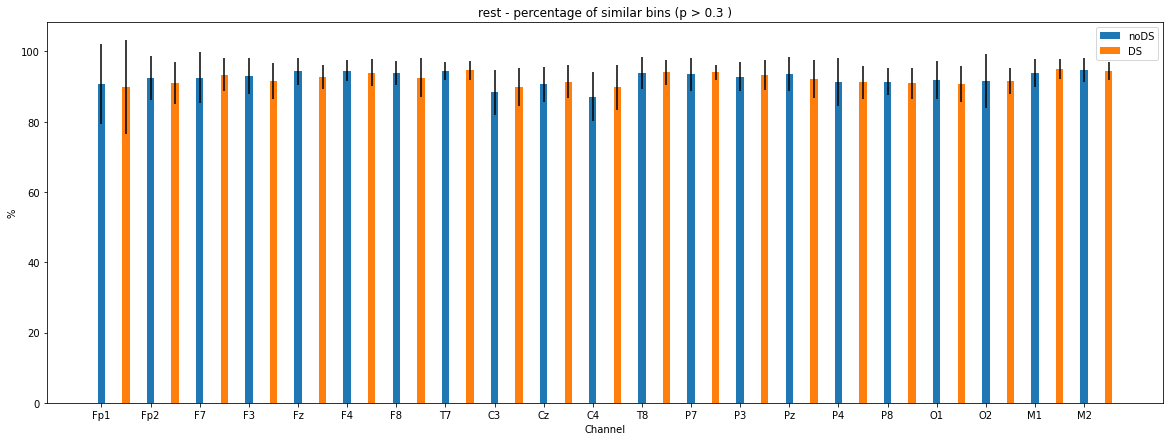

In [49]:
percent = list()
percent2 = list()
for subject in range (1, 13):
    same = np.sum(out[subject]['rest'] >= 0.3, axis=(1,2))
    same2 = np.sum(out2[subject]['rest'] >= 0.3, axis=(1,2))
    different = np.sum(out[subject]['rest'] < 0.3, axis=(1,2))
    different2 = np.sum(out2[subject]['rest'] < 0.3, axis=(1,2))
    percent.append(same/ ( same+different) * 100)
    percent2.append(same2/ ( same2+different2) * 100)

percent = np.array(percent)
percent2 = np.array(percent2)

mean = np.mean(percent, axis = 0)
mean2 = np.mean(percent2, axis = 0)
std = np.std(percent, axis = 0)
std2 = np.std(percent2, axis = 0)

plt.figure(figsize=(20, 7), facecolor='w');
plt.bar(range(1,21*2, 2), mean, align='center', width=0.3, label='noDS');
plt.bar(range(2,22*2, 2), mean2, align='center', width=0.3, label='DS');
plt.errorbar(range(1,21*2,2), mean, yerr=std, fmt=" ", color="k")
plt.errorbar(range(2,22*2,2), mean2, yerr=std2, fmt=" ", color="k")
plt.xticks(range(1,21*2, 2), CHANNELS);
plt.xlabel('Channel')
plt.ylabel('%')
plt.title('rest - percentage of similar bins (p > 0.3 )')
plt.legend()



In [53]:
for i in range(len(mean)):
    if mean[i] > mean2[i]:
        print(CHANNELS[i])
        print('No Downs wins by ', mean[i] - mean2[i], '%' )
    else:
        print([CHANNELS[i]])
        print('Ds wins ', mean2[i] - mean[i], '%')

Fp1
No Downs wins by  0.8953168044077273 %
Fp2
No Downs wins by  1.5457606366697405 %
['F7']
Ds wins  0.9794918885827855 %
F3
No Downs wins by  1.3161922252831033 %
Fz
No Downs wins by  1.6605448423630378 %
F4
No Downs wins by  0.5356596265687017 %
F8
No Downs wins by  1.4386287113559888 %
['T7']
Ds wins  0.16069788797059914 %
['C3']
Ds wins  1.6146311600856933 %
['Cz']
Ds wins  0.6657483930211328 %
['C4']
Ds wins  2.647689011325383 %
['T8']
Ds wins  0.18365472910926428 %
['P7']
Ds wins  0.6045301499847113 %
['P3']
Ds wins  0.45148454239362934 %
Pz
No Downs wins by  1.430976430976429 %
P4
No Downs wins by  0.076522803795541 %
P8
No Downs wins by  0.5433119069482899 %
O1
No Downs wins by  1.0713192531374176 %
O2
No Downs wins by  0.030609121518210713 %
['M1']
Ds wins  1.1248852157942935 %
M2
No Downs wins by  0.3213957759411983 %


In [ ]:
path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/single_subjects_on_pretrained/rest_right/'
mapping = {'right': 0, 'rest': 1}
stage = 4
data_path =  '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/'
data_name = 'rest_right'
deep4_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Models/ZCA_prewhitened/'

metrics = dict()

for subject in range (1, 13):
    gan_path = os.path.join(path, f'{subject}')

    real, fake = create_balanced_datasets(gan_path, data_path, data_name, stage, subject)
    metrics[subject] = calculate_metrics(real, fake, stage, data_name, 250, deep4_path)

In [13]:
IS = list()
swd = list()
clas = list()

for subject in range (1, 13):
    swd.append(metrics[subject].iloc[1]['SWD'])
    IS.append(metrics[subject].iloc[1]['IS'])
    clas.append(metrics[subject].iloc[1]['classification'][0])


In [ ]:
import statsmodels.api as sm

gan_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/ZCA_prewhitened/cGAN/1-14/'
data_path =  '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/ZCA_prewhitened/'
data_name = 'rest_right'
subject = 4

stage = 4
real, fake = create_balanced_datasets(gan_path, data_path, data_name, stage, subject)

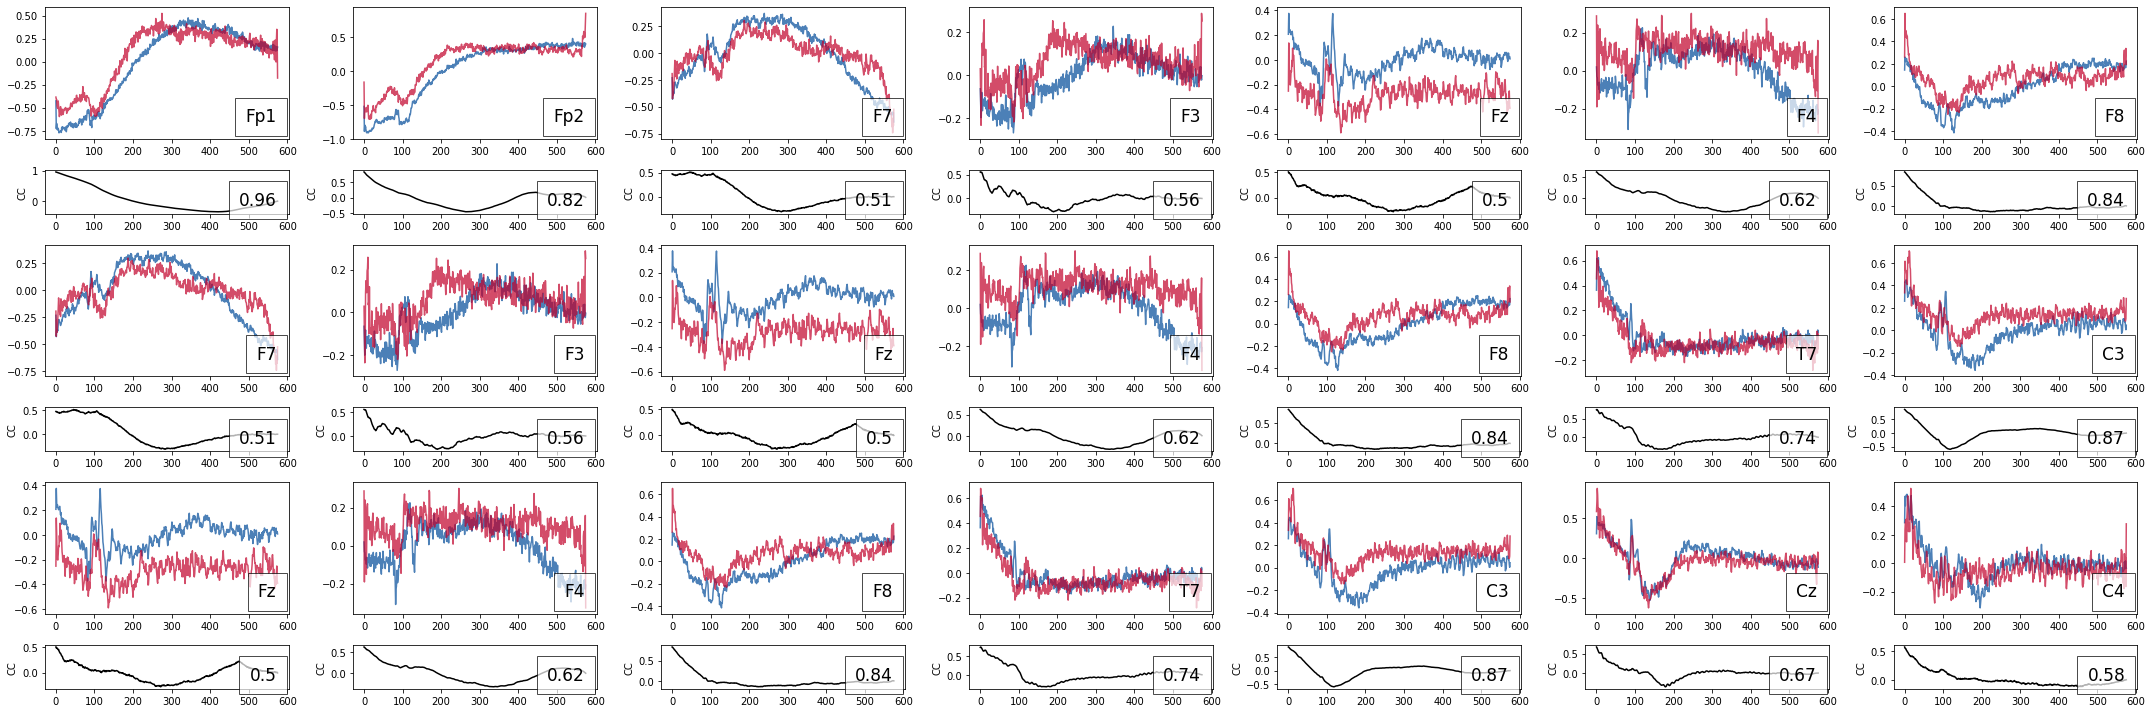

In [207]:
r = np.mean(real.X[:, :, :], axis = 0)
f = np.mean(fake.X[:, :, :], axis = 0)

is_data = True

_, axs = plt.subplots(6, 7,  figsize=(30, 10), facecolor='w', gridspec_kw={'height_ratios': [3, 1]*3})
for row, row_ax in enumerate(axs):

    for col, col_ax in enumerate(row_ax):
        if is_data:
            col_ax.plot(r[int(row+col)], color='#004a99', alpha=.7)
            col_ax.plot(f[int(row+col)], color='#c1002a', alpha=.7)
            col_ax.text(.95, .1, CHANNELS[int(row+col)], fontsize=17, ha='right', va='bottom', transform=col_ax.transAxes,
                        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
        else:
            cc = sm.tsa.stattools.ccf(r[int(row+col)], f[int(row+col)], adjusted=False)
            col_ax.plot(cc, color='k')
            col_ax.set_ylabel('CC')
            col_ax.text(.95, .1, round(np.max(cc), 2), fontsize=17, ha='right', va='bottom', transform=col_ax.transAxes,
                        bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 10})
    is_data = not is_data
plt.tight_layout()
    
    
    

In [19]:
r = np.mean(real.X[:, :, :], axis = 0)
f = np.mean(fake.X[:, :, :], axis = 0)
print(real.X.shape)

cc = np.corrcoef(r[0], f[0])

(528, 21, 576)


In [15]:
correlationCoef = list()
for i in range(21):
    cc = np.corrcoef(r[i], f[i])[0, 1]
    correlationCoef.append(cc) 

In [17]:
np.mean(correlationCoef)

0.4532895316091662

In [3]:
dn = 'baseline'
dp = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/Thesis/'
real = load_dataset(dn, dp) 

In [13]:
for subject in range(1, 15):
    train = real.train_data.return_subject(subject)
    test = real.test_data.return_subject(subject)
    print(subject, ' n data train',train.X.shape[0])
    print(subject, ' n rest', train.y.sum())
    print(subject, ' n data test',test.X.shape[0])
    print(subject, ' n rest', test.y.sum())

1  n data train 160
1  n rest 80
1  n data test 80
1  n rest 40
2  n data train 407
2  n rest 203
2  n data test 80
2  n rest 40
3  n data train 440
3  n rest 220
3  n data test 80
3  n rest 40
4  n data train 448
4  n rest 224
4  n data test 80
4  n rest 40
5  n data train 360
5  n rest 180
5  n data test 80
5  n rest 40
6  n data train 440
6  n rest 220
6  n data test 80
6  n rest 40
7  n data train 440
7  n rest 220
7  n data test 80
7  n rest 40
8  n data train 327
8  n rest 163
8  n data test 80
8  n rest 40
9  n data train 440
9  n rest 220
9  n data test 80
9  n rest 40
10  n data train 440
10  n rest 220
10  n data test 80
10  n rest 40
11  n data train 440
11  n rest 220
11  n data test 80
11  n rest 40
12  n data train 440
12  n rest 220
12  n data test 80
12  n rest 40
13  n data train 400
13  n rest 200
13  n data test 80
13  n rest 40
14  n data train 440
14  n rest 220
14  n data test 80
14  n rest 40


In [39]:
deep4_path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Models/Thesis/'
data_name = 'baseline'
stage = 6

In [9]:
dn = 'baseline'
dp = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/Thesis/'
real = load_dataset(dn, dp) 

In [5]:
from torchinfo import summary

In [168]:
path = '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Models/Thesis/' 

acc_bl = list()

for i in range(6):
    stage_mean = []
    for j in range(10):
        dict_name = f'baseline_Deep4_stage{i}_{j}deep4_log.dict'
        log_dict = joblib.load(os.path.join(path, dict_name))
        acc_bl.append(log_dict['test_acc'][0])
        stage_mean.append(log_dict['test_acc'][0])
    

acc_zca = list()

for i in range(6):
    stage_mean = []
    for j in range(10):
        dict_name = f'whitened_Deep4_stage{i}_{j}deep4_log.dict'
        log_dict = joblib.load(os.path.join(path, dict_name))
        acc_zca.append(log_dict['test_acc'][0])
        stage_mean.append(log_dict['test_acc'][0])
    

acc_up = list()

#for i in range(7):
#    for j in range(10):
#        dict_name = f'upsampled_Deep4_stage{i}_{j}deep4_log.dict'
#        log_dict = joblib.load(os.path.join(path, dict_name))
#        acc_up.append(log_dict['test_acc'][0])



0 51.13636322021485
1 66.36363487243652
2 75.68181838989258
3 72.27272682189941
4 73.18181762695312
5 73.63636322021485
0 53.63636360168457
1 66.81818084716797
2 71.59090805053711
3 72.95454483032226
4 71.8181812286377
5 69.54545364379882


In [15]:
log_dict

{'training_acc': [33.97321319580078,
  51.85714340209961,
  63.421875,
  70.74256134033203,
  75.55245208740234,
  78.81339263916016,
  81.32737731933594,
  83.28189086914062,
  84.86663055419922,
  86.10862731933594,
  87.15625],
 'loss': [4.553113869258335,
  0.9414399070399148,
  0.4908310783760888,
  0.3306086067642484,
  0.2619558606828962,
  0.23608605861663817,
  0.15870926060846874,
  0.13017643921609437,
  0.09580298159271479,
  0.08998710392042994,
  0.07872228710246938],
 'epoch': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'test_acc': [61.3636360168457]}

In [164]:
all = np.concatenate((acc_bl, acc_zca, acc_up))

In [171]:
stage_mean = list()
for i in range(6):
    stage_mean.append(np.mean(np.array([all[i : i + 10], all[i*2 : i*2 + 10]] )))

In [172]:
stage_mean

[51.13636322021485,
 53.40909061431885,
 55.681817817687985,
 57.840908241271975,
 60.22727184295654,
 62.61363525390625]

In [5]:
real, fake =  create_balanced_datasets('/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Results/Thesis/cGAN',
                                        '/home/samuelboehm/boehms/eeg-gan/EEG-GAN/Data/Data/Thesis/',
                                        'whitened',
                                        5,
                                        None,
                                        False,
                                        256)

In [45]:
first = np.mean(real.X[:, :, :], axis=0)
first1 = np.mean(fake.X[:, :, :], axis=0)

In [47]:
corr = np.corrcoef(first, first1, rowvar=True)

In [48]:
corr.shape

(42, 42)

In [49]:
corr

array([[ 1.        ,  0.91426086,  0.15116038, ..., -0.49310916,
        -0.2269417 , -0.35164311],
       [ 0.91426086,  1.        ,  0.18013859, ..., -0.4702321 ,
        -0.14731171, -0.29052919],
       [ 0.15116038,  0.18013859,  1.        , ..., -0.01136129,
         0.03311993, -0.10889058],
       ...,
       [-0.49310916, -0.4702321 , -0.01136129, ...,  1.        ,
         0.12220308,  0.0410809 ],
       [-0.2269417 , -0.14731171,  0.03311993, ...,  0.12220308,
         1.        ,  0.54998689],
       [-0.35164311, -0.29052919, -0.10889058, ...,  0.0410809 ,
         0.54998689,  1.        ]])

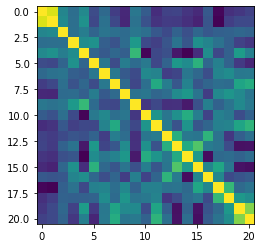

In [55]:
first = np.mean(real.X[:, :, :], axis=0)
first1 = np.mean(fake.X[:, :, :], axis=0)
corr = np.corrcoef(first, first1, rowvar=True)
plt.imshow(corr[:21, :21])

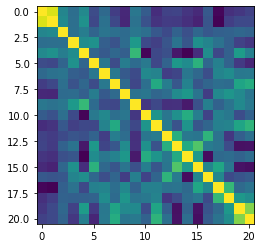

In [56]:
first = np.mean(real.X[:, :, :], axis=0)
first1 = np.mean(real.X[:, :, :], axis=0)
corr = np.corrcoef(first, first1, rowvar=True)
plt.imshow(corr[:21, :21])

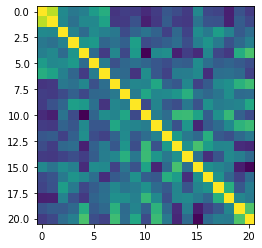

In [57]:
first = np.mean(fake.X[:, :, :], axis=0)
first1 = np.mean(fake.X[:, :, :], axis=0)
corr = np.corrcoef(first, first1, rowvar=True)
plt.imshow(corr[:21, :21])